In [3]:
import os, sys
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from neuromaps.images import load_data
from neuromaps.images import dlabel_to_gifti
from netneurotools import datasets as nntdata
from nilearn.datasets import fetch_atlas_schaefer_2018
from statsmodels.stats.multitest import multipletests
from scipy.io import loadmat, savemat
from neuromaps import images, nulls
from scipy.stats import pearsonr

ref_path = r"D:\OneDrive\\References\Farahani_ALS-main\codes"  ## https://github.com/netneurolab/Farahani_ALS/tree/main/codes

sys.path.append(ref_path)

from globals import path_results, path_fig, nnodes, path_atlas, path_surface, path_wb_command


In [4]:
#------------------------------------------------------------------------------
# Load von-economo atlas information
#------------------------------------------------------------------------------
def load_von_economo_atlas(path_in, nnodes):
    atlas_data = np.squeeze(scipy.io.loadmat(path_in + 'economo_Schaefer400.mat')['pdata'])
    return atlas_data - 1, ['primary motor',
                            'association',
                            'association',
                            'primary/secondary sensory',
                            'primary sensory',
                            'limbic',
                            'insular']
def load_Yeo7_atlas(path_in, nnodes):
    atlas_data = np.squeeze(scipy.io.loadmat(path_in + 'Yeo7_Schaefer400.mat')['yeodata'])
    return atlas_data - 1, ['visual',
                            'somatomotor',
                            'dorsal attention',
                            'salience/ventral attention',
                            'limbic',
                            'control',
                            'default']
    
    
atlas_7Network_von, label_von_networks = load_von_economo_atlas(path_atlas, nnodes)
atlas_7Network_yeo, label_yeo_networks = load_Yeo7_atlas(path_atlas, nnodes)
num_labels = len(label_von_networks)
# savemat('atlas_7Network_yeo.mat',{'Yeo_label':atlas_7Network_yeo})

In [7]:
#------------------------------------------------------------------------------
# Load group-averegd W-score data 
#------------------------------------------------------------------------------
tmp  = loadmat(f'D:\\OneDrive\\5_TMS_response\\CT_Wscore53avg_S400_7Net_vHCP2.mat')
disease_profile = tmp['Wscore_s400_7Net'].squeeze()

#------------------------------------------------------------------------------
# Load SC ##https://github.com/netneurolab/hansen_many_networks/tree/085151024a2f8dda1f07ce13e946def1aec93f17/data/Schaefer400
#------------------------------------------------------------------------------
hansen_dir ='D:\\OneDrive\\References\\hansen_many_networks-master\\data\\Schaefer400\\'
sc = np.load(hansen_dir + 'consensusSC.npy')


In [8]:
def compute_neighbor_W_means(G, disease_profile, Yeo7_label, num_networks=7):
    """
    Compute the mean W-score value of each node’s neighbors within each of the Yeo7 networks.
    
    Parameters:
        G (ndarray):adjacency matrix (N x N)
        disease_profile (ndarray): W-score values for each node
        Yeo7_label (ndarray): Yeo7 network label for each node 
        num_networks (int): Number of networks

    Returns:
        nei_Yeo (ndarray): Mean W-score of each node’s neighbors within each network (N × 7)
    """
    nodenum = G.shape[0]
    nei_Yeo = np.zeros((nodenum, num_networks))

    for i in range(nodenum):
        neighbors = np.where(G[:, i] != 0)[0]
        neighbor_W = disease_profile[neighbors]
        neighbor_labels = Yeo7_label[neighbors]
        
        for j in range(num_networks):
            label_indices = np.where(neighbor_labels == j)[0]
            if len(label_indices) > 0:
                nei_Yeo[i, j] = np.mean(neighbor_W[label_indices])
            else:
                nei_Yeo[i, j] = np.nan  
    return nei_Yeo


In [9]:
def compute_system_level_correlation(disease_profile, atlas_7Network_yeo, nei_Yeo, min_valid=10):
    """
    Compute the correlation between networks (Figure 2D)

    Parameters:
        disease_profile (ndarray): W-score values for each node
        atlas_7Network_yeo (ndarray): Yeo7 network label for each node
        nei_Yeo (ndarray): Mean neighbor W-score values of each node across networks (N x 7)
        min_valid (int): Minimum number of valid data points required. Default is 10.

    Returns:
        r_yeo (ndarray): Correlation matrix between networks (7 x 7)
    """
    from statsmodels.stats.multitest import fdrcorrection


    num_networks = 7
    r_yeo = np.zeros((num_networks, num_networks))
    p_yeo = np.ones((num_networks, num_networks))

    for i in range(num_networks):
        indices_i = np.where(atlas_7Network_yeo == i)[0]
        T_i = disease_profile[indices_i]
        for j in range(num_networks):
            nei_j = nei_Yeo[indices_i, j]
            valid = ~np.isnan(nei_j)
            if np.sum(valid) < min_valid:
                r_yeo[i , j ] = 0
                p_yeo[i , j ] = 1
            else:
                r, p = pearsonr(T_i[valid], nei_j[valid])
                n = np.sum(valid)
                adj_rs = 1 - (1 - r**2) * (n - 1) / (n - 2)
                adj_rs = max(0, adj_rs)  # ensure non-negativity
                
                r_yeo[i , j] = np.sign(r) * np.sqrt(adj_rs)
                p_yeo[i , j] = p
    p_flat = p_yeo.flatten()
    _, p_fdr_flat = fdrcorrection(p_flat)


    p_fdr_flat = p_fdr_flat.reshape(p_yeo.shape)
    
    return r_yeo, p_fdr_flat

In [12]:
##  YEO
nei_Yeo = compute_neighbor_W_means(sc, disease_profile, atlas_7Network_yeo)
r_yeo, p_fdr_yeo = compute_system_level_correlation(disease_profile, atlas_7Network_yeo, nei_Yeo)
mask_yeo = p_fdr_yeo >= 0.05


In [13]:
## VON 
nei_Von = compute_neighbor_W_means(sc, disease_profile, atlas_7Network_von)
r_von, p_fdr_von = compute_system_level_correlation(disease_profile, atlas_7Network_von, nei_Von)
mask_von = p_fdr_von >= 0.05


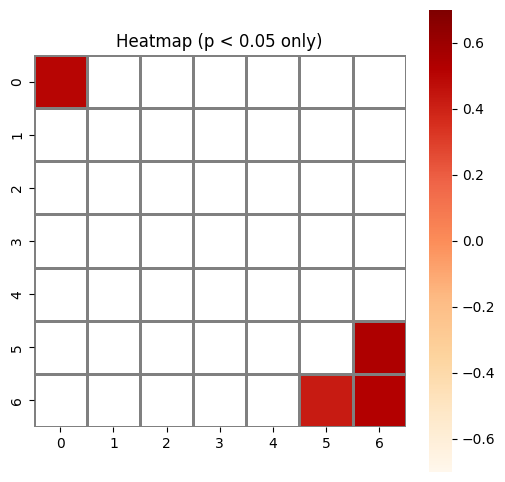

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
##Yeo
plt.figure(figsize=(6, 6))
sns.heatmap(r_yeo, 
            mask=mask_yeo, 
            cmap="OrRd", 
            square=True, 
            linewidths=.75, 
            linecolor='grey', 
            cbar=True,
            vmin=-0.7,
            vmax=0.7)

plt.title("Heatmap (p < 0.05 only)")
current_dir = os.getcwd()
plt.savefig(os.path.join(current_dir, 'yeo.pdf'),dpi = 300)
plt.show()


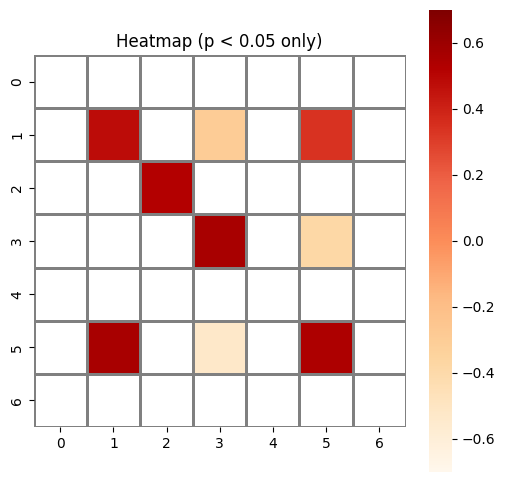

In [15]:
##Von
plt.figure(figsize=(6, 6))
sns.heatmap(r_von, 
            mask=mask_von, 
            cmap="OrRd", 
            square=True, 
            linewidths=.75, 
            linecolor='grey', 
            cbar=True,
            vmin=-0.7,
            vmax=0.7)

plt.title("Heatmap (p < 0.05 only)")
current_dir = os.getcwd()
plt.savefig(os.path.join(current_dir, 'von.pdf'),dpi = 300)
plt.show()
